## Set Up

In [ ]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import savgol_filter

%matplotlib inline

## Load Data

In [ ]:
sales_df = pd.read_csv('sales.csv')
sales_df.head()

date store_id cat_id    sales
0  2011-01-29     TX_1  FOODS  3950.35
1  2011-01-30     TX_1  FOODS  3844.97
2  2011-01-31     TX_1  FOODS  2888.03
3  2011-02-01     TX_1  FOODS  3631.28
4  2011-02-02     TX_1  FOODS  3072.18

In [ ]:
sales_df.shape

(58230, 4)

In [ ]:
# unique count of store_id and cat_id
print(f'Number of Unique Stores:{sales_df.store_id.nunique()}')
print(f'Number of Unique Categories:{sales_df.cat_id.nunique()}')

Number of Unique Stores:10
Number of Unique Categories:3


In [ ]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58230 entries, 0 to 58229
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      58230 non-null  object 
 1   store_id  58230 non-null  object 
 2   cat_id    58230 non-null  object 
 3   sales     58230 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.8+ MB


In [ ]:
#change datatype of date columns
sales_df['date'] = sales_df['date'].astype('datetime64[ns]')

In [ ]:
#check data type after dtype change
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58230 entries, 0 to 58229
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      58230 non-null  datetime64[ns]
 1   store_id  58230 non-null  object        
 2   cat_id    58230 non-null  object        
 3   sales     58230 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 1.8+ MB


In [ ]:
#date range
print(f'Data is from {min(sales_df.date)} to {max(sales_df.date)}')

Data is from 2011-01-29 00:00:00 to 2016-05-22 00:00:00


## Data Preprocessing

### Irregular Time Intervals

#### Check for duplicates in Data

In [ ]:
sales_df.duplicated(keep = False).value_counts()

False    58230
dtype: int64

#### Check for duplicates in dates

In [ ]:
storeid = list(sales_df['store_id'].unique())
catid = list(sales_df['cat_id'].unique())

In [ ]:
# check for duplicate dates within a store and category group
for store in storeid:
  for cat in catid:
    df = sales_df[(sales_df.store_id == store) & (sales_df.cat_id == cat)]
    print(f"Duplicates for {store} store and {cat} category : {len(df)}: {min(df.date)}: {max(df.date)} : {df.duplicated(subset=['date']).any()}")

Duplicates for TX_1 store and FOODS category : 1941: 2011-01-29 00:00:00: 2016-05-22 00:00:00 : False
Duplicates for TX_1 store and HOBBIES category : 1941: 2011-01-29 00:00:00: 2016-05-22 00:00:00 : False
Duplicates for TX_1 store and HOUSEHOLD category : 1941: 2011-01-29 00:00:00: 2016-05-22 00:00:00 : False
Duplicates for TX_2 store and FOODS category : 1941: 2011-01-29 00:00:00: 2016-05-22 00:00:00 : False
Duplicates for TX_2 store and HOBBIES category : 1941: 2011-01-29 00:00:00: 2016-05-22 00:00:00 : False
Duplicates for TX_2 store and HOUSEHOLD category : 1941: 2011-01-29 00:00:00: 2016-05-22 00:00:00 : False
Duplicates for TX_3 store and FOODS category : 1941: 2011-01-29 00:00:00: 2016-05-22 00:00:00 : False
Duplicates for TX_3 store and HOBBIES category : 1941: 2011-01-29 00:00:00: 2016-05-22 00:00:00 : False
Duplicates for TX_3 store and HOUSEHOLD category : 1941: 2011-01-29 00:00:00: 2016-05-22 00:00:00 : False
Duplicates for CA_1 store and FOODS category : 1941: 2011-01-29 

No duplicate dates within a store and catg group. All combinations have 1941 unique dates with same start and end dates

### Outliers

Detrend the sales column and then check for outliers using IQR method

#### Identifying Outliers

In [ ]:
def outlier_detection(sales_series_df):
    """
    This function adds column 'anomaly' to dataframe to mark outliers as True, non-outliers as False. 
    """
    # calculate interquartile range
    Q1 = sales_series_df['sales_detrend'].quantile(0.25)
    Q3 = sales_series_df['sales_detrend'].quantile(0.75)
    IQR = Q3 - Q1

    # identify outliers
    # Filtering Values between Q1-3IQR and Q3+3IQR
    sales_series_df['anomaly'] = (sales_series_df.sales_detrend >= Q3 + 3*IQR) | (sales_series_df.sales_detrend <= Q1 - 3*IQR)
    
    return sales_series_df

In [ ]:
outlier_marked_list = []

for store in sales_df.store_id.unique():
    for category in sales_df.cat_id.unique():
        sales_series_df = sales_df.loc[(sales_df.store_id==store) & (sales_df.cat_id==category), :]
        # detrend sales for better detection of outliers
        sales_series_df['sales_detrend'] = signal.detrend(sales_series_df['sales'].values)
        sales_outlier_marked_df = outlier_detection(sales_series_df)
        outlier_marked_list.append(sales_outlier_marked_df)

outlier_marked_df = pd.concat(outlier_marked_list)

<ipython-input-15-61609152a738>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_series_df['sales_detrend'] = signal.detrend(sales_series_df['sales'].values)
<ipython-input-14-c2d3b7410390>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_series_df['anomaly'] = (sales_series_df.sales_detrend >= Q3 + 3*IQR) | (sales_series_df.sales_detrend <= Q1 - 3*IQR)


#### Visualizing Outliers

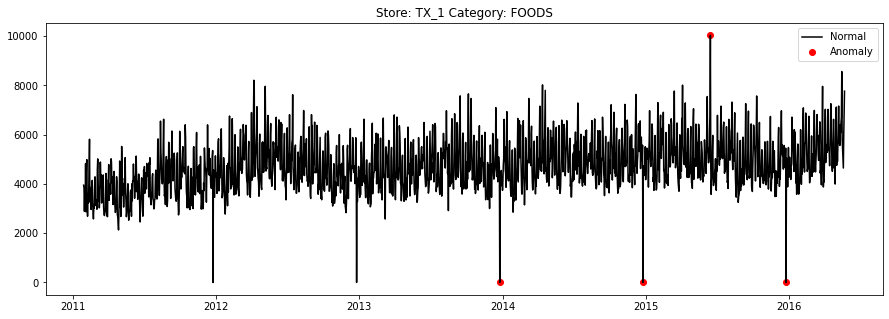

In [ ]:
def visualize_outliers(store,category):

  df = outlier_marked_df.loc[(outlier_marked_df.store_id == store) & (outlier_marked_df.cat_id == category),:]
  
  # visualization of outliers detected
  fig, ax = plt.subplots(figsize=(15,5))
  a = df.loc[df['anomaly'] == 1, ['date', 'sales']] #anomaly
  ax.plot(df.date, df['sales'], color='black', label = 'Normal')
  ax.scatter(a.date, a['sales'], color='red', label = 'Anomaly')
  plt.title(f'Store: {store} Category: {category}')
  plt.legend()
  plt.show()

# sample one of the store category to see how our outlier detection performs
visualize_outliers('TX_1', 'FOODS')

**It seems like the end of the year has some outliers which have zero sales**

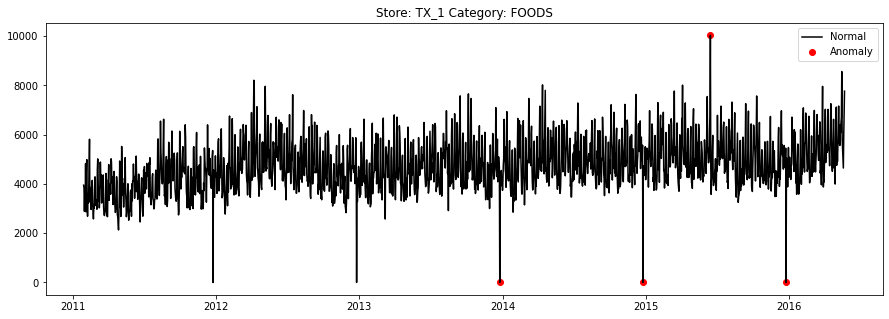

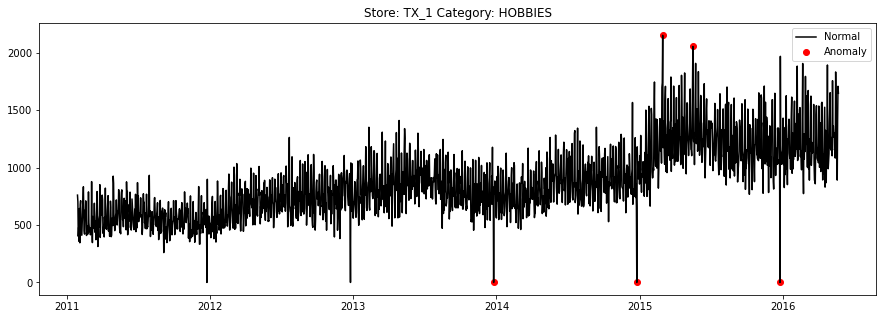

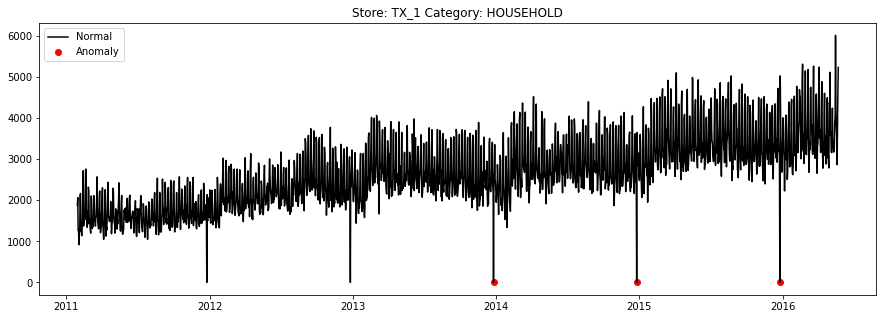

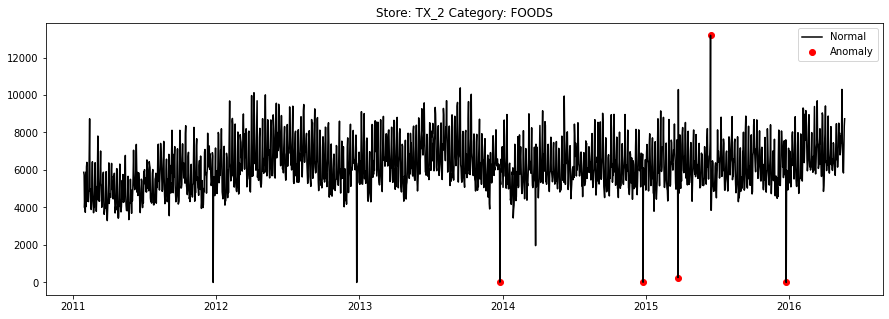

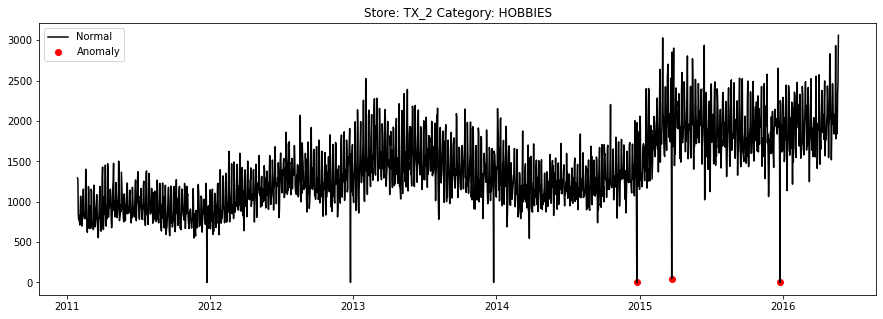

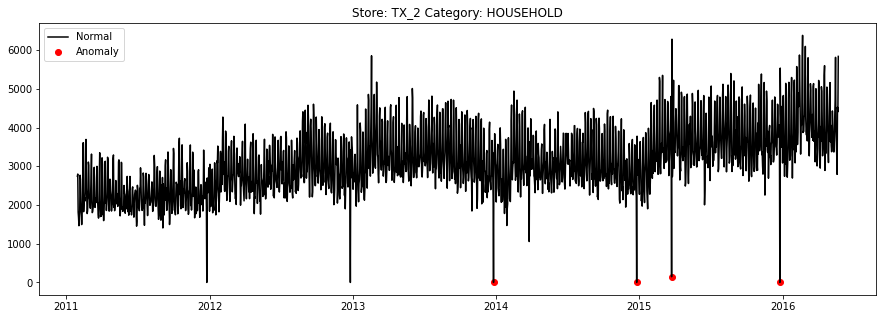

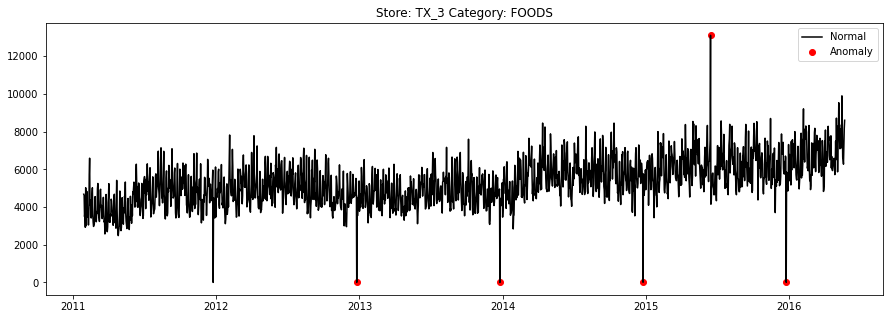

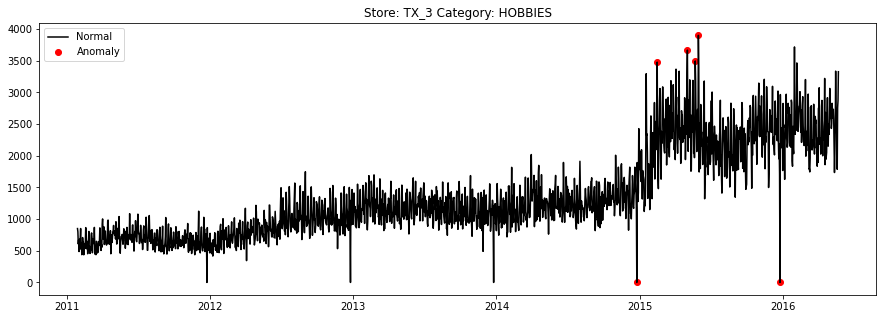

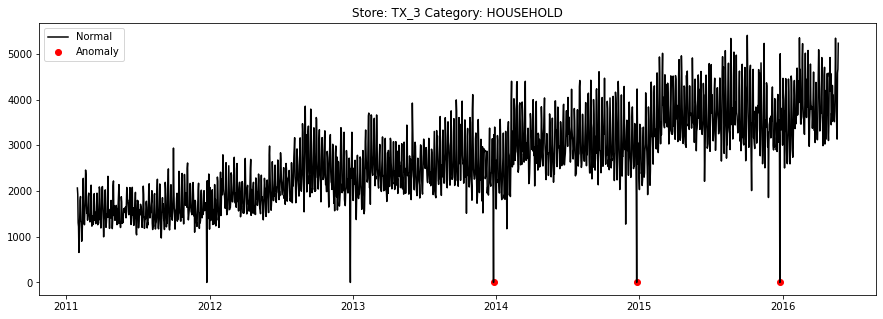

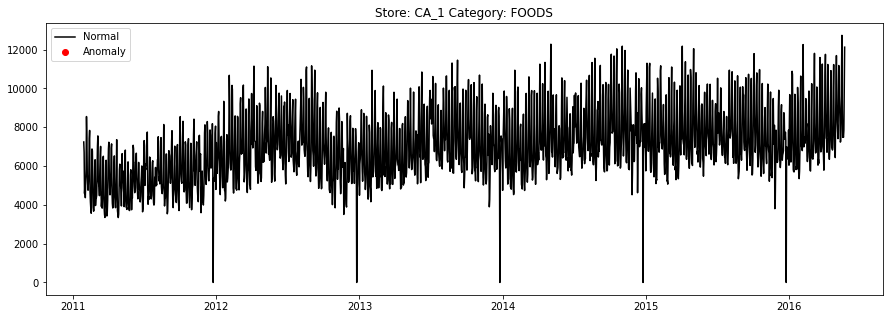

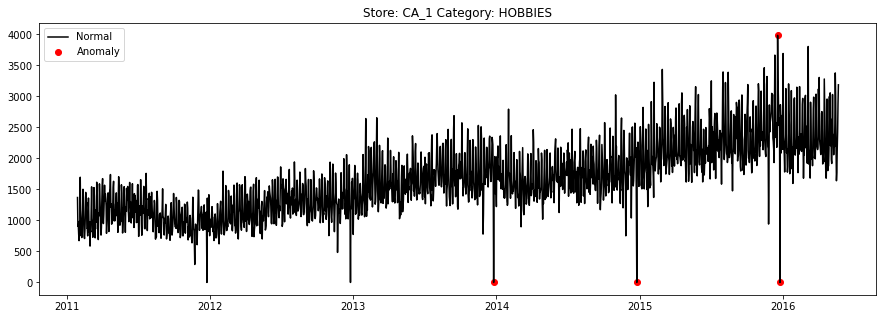

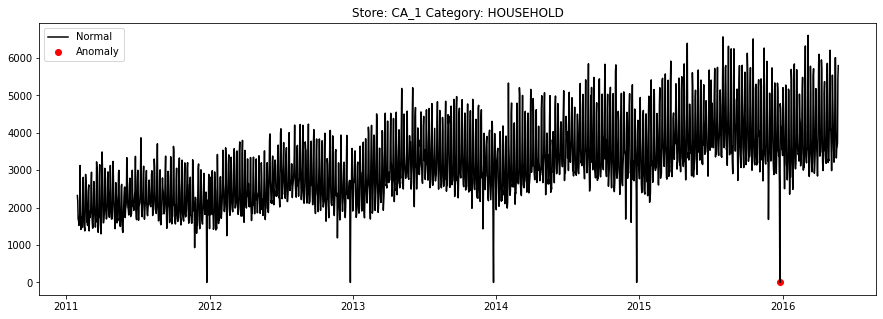

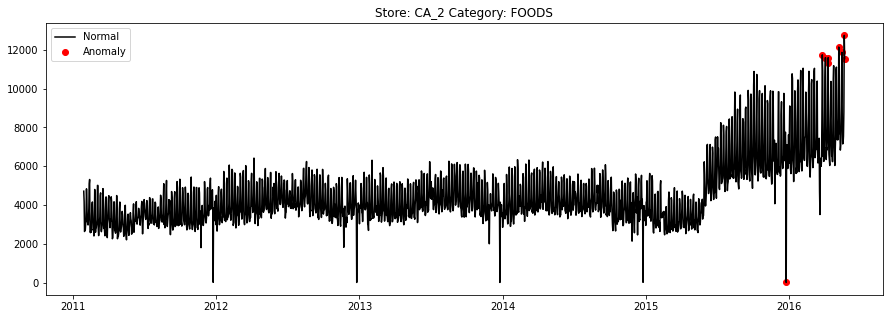

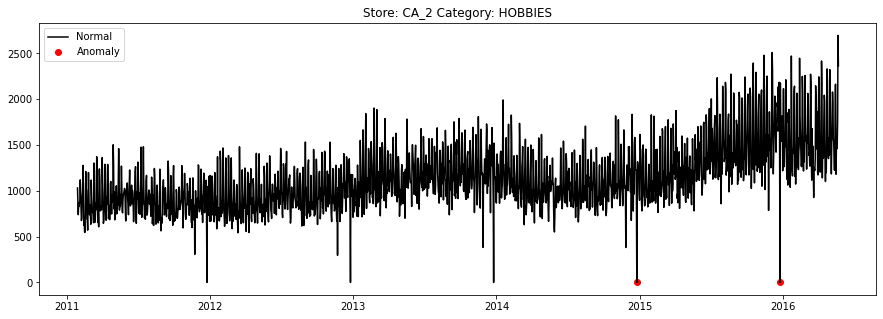

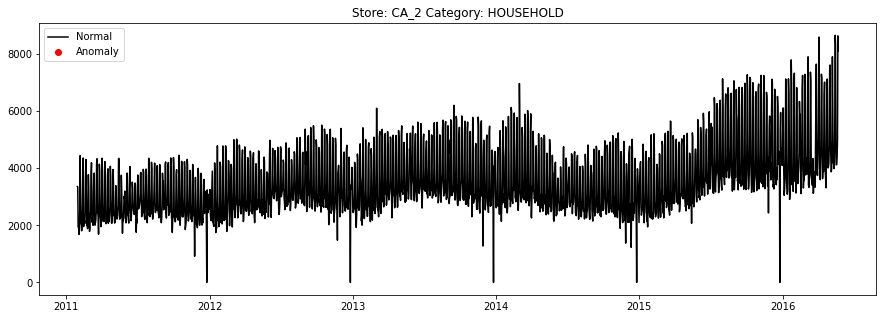

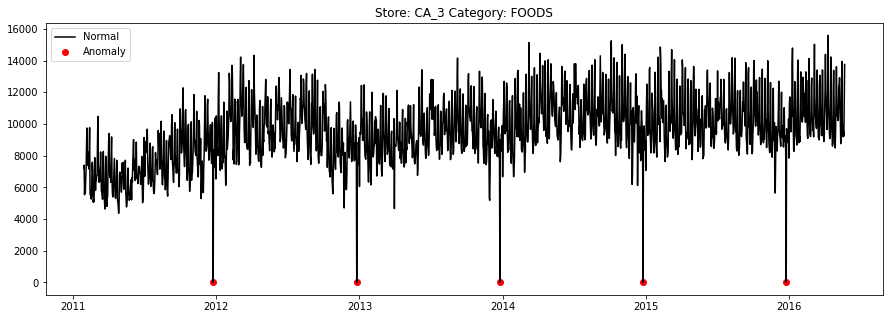

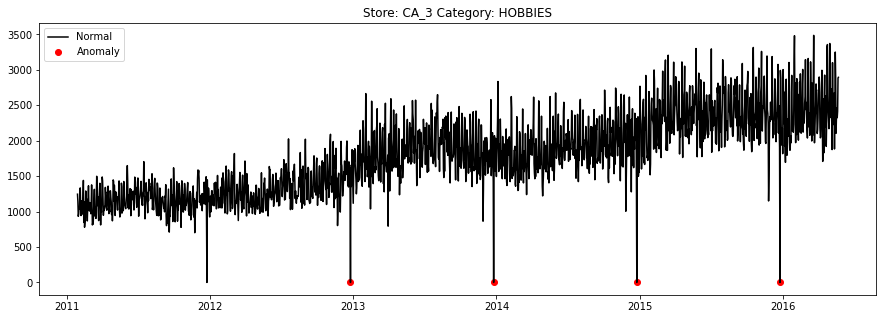

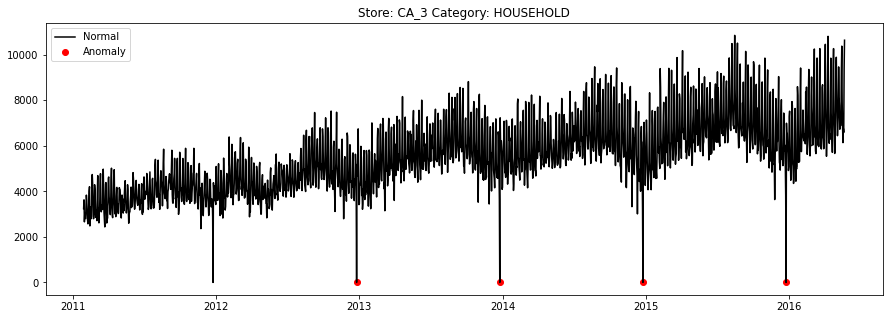

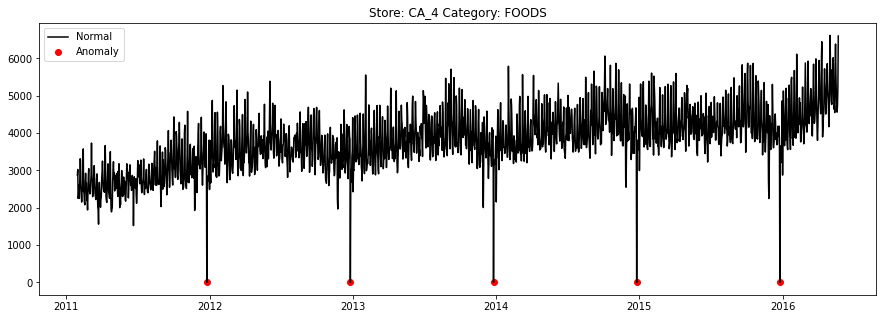

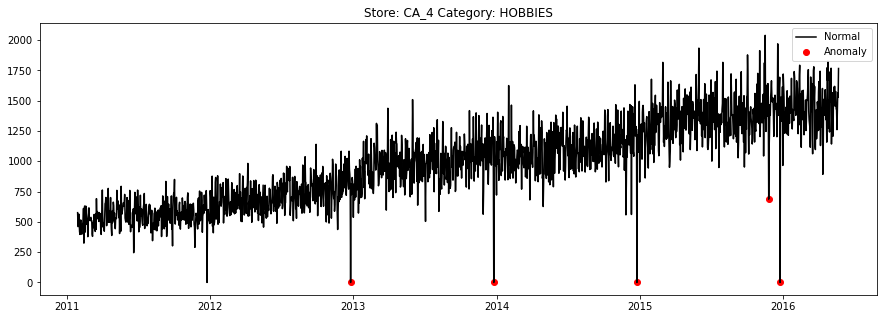

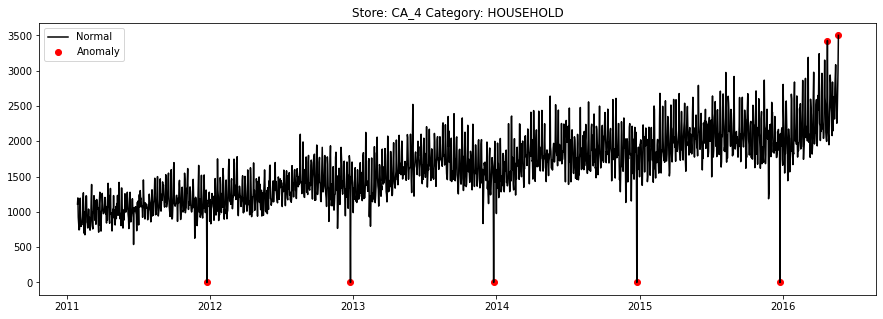

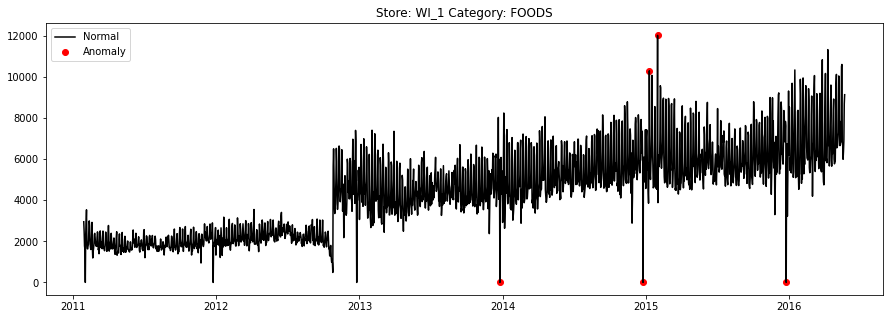

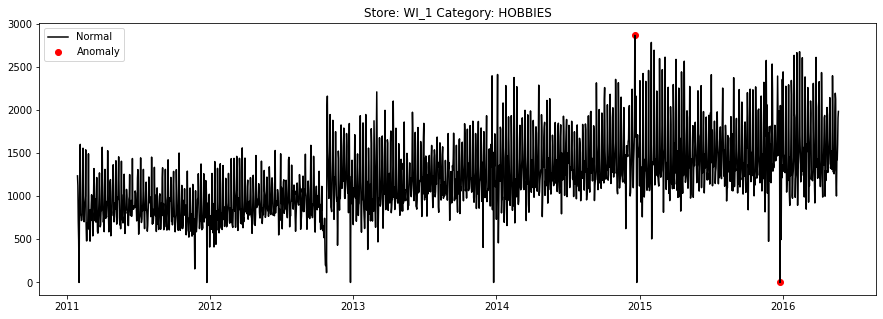

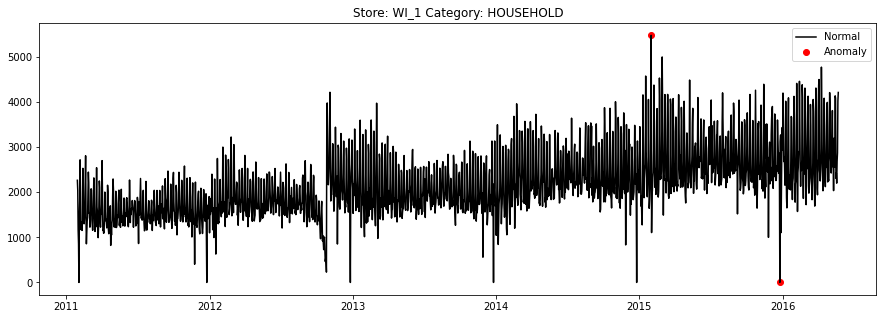

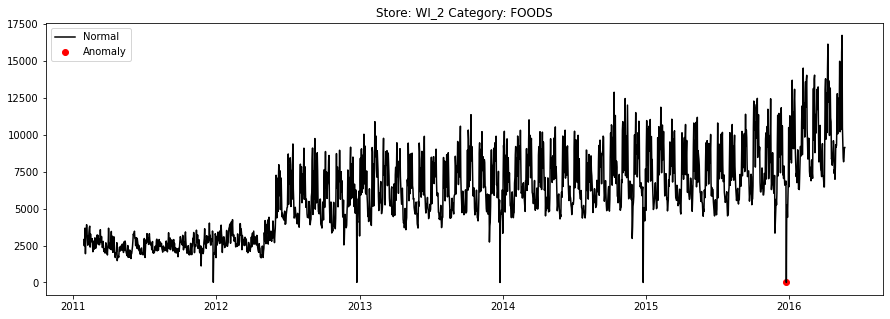

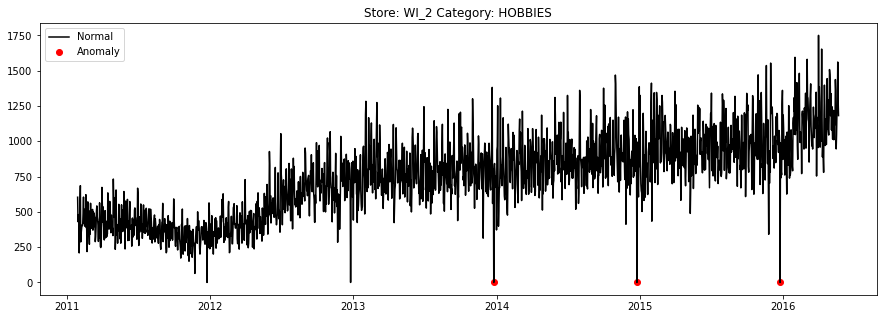

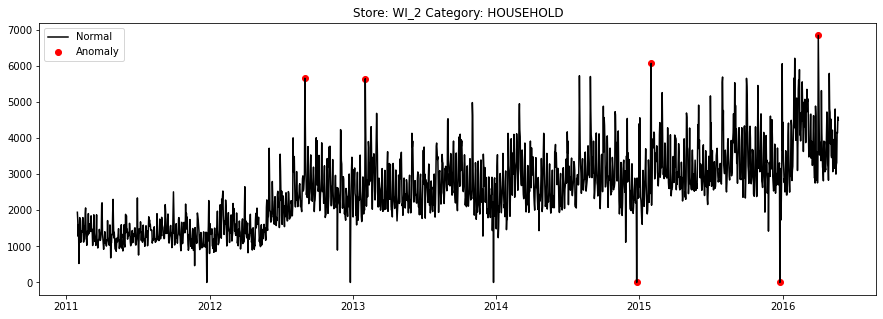

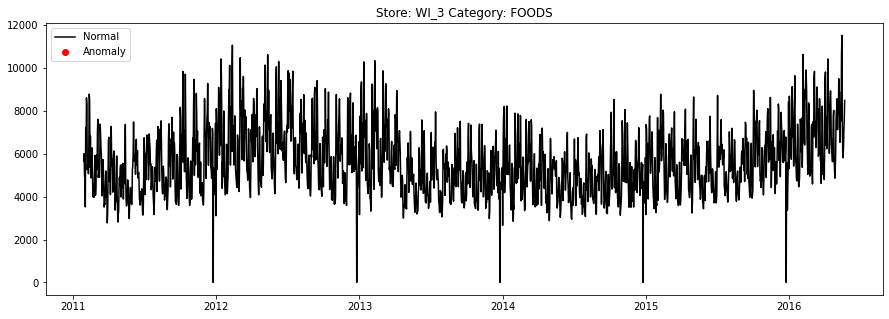

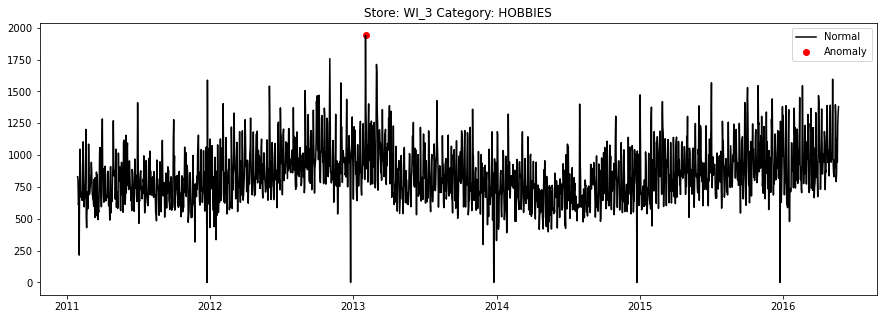

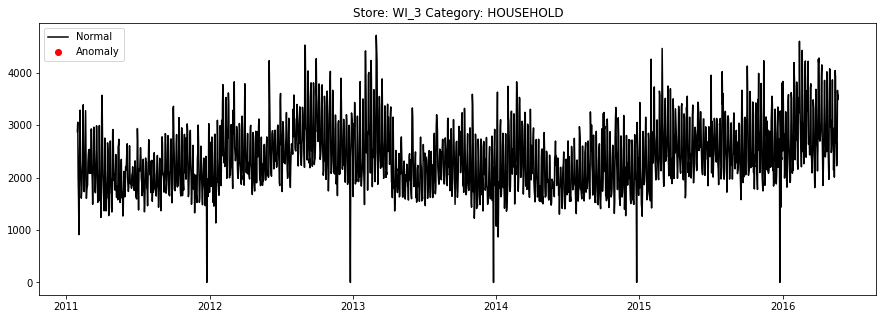

In [ ]:
#check the graph for every store and category combination
for store in sales_df.store_id.unique():
    for category in sales_df.cat_id.unique():
      visualize_outliers(store,category)

We can observe that there are almost no sales at the year end on one particular date in the year end

In [ ]:
outlier_marked_df.loc[outlier_marked_df.sales < 100,:]

date store_id     cat_id  sales  sales_detrend  anomaly
330   2011-12-25     TX_1      FOODS   0.00   -4325.732392    False
696   2012-12-25     TX_1      FOODS   0.00   -4564.055431    False
1061  2013-12-25     TX_1      FOODS   1.58   -4800.147315     True
1426  2014-12-25     TX_1      FOODS   0.00   -5039.399199     True
1791  2015-12-25     TX_1      FOODS   1.58   -5275.491082     True
...          ...      ...        ...    ...            ...      ...
56619 2011-12-25     WI_3  HOUSEHOLD   0.00   -2244.693915    False
56985 2012-12-25     WI_3  HOUSEHOLD   0.00   -2328.663615    False
57350 2013-12-25     WI_3  HOUSEHOLD   0.00   -2412.403890    False
57715 2014-12-25     WI_3  HOUSEHOLD   0.00   -2496.144164    False
58080 2015-12-25     WI_3  HOUSEHOLD   0.00   -2579.884439    False

[155 rows x 6 columns]

In [ ]:
outlier_marked_df['anomaly'].value_counts()

False    58126
True       104
Name: anomaly, dtype: int64

Christmas days have almost no sales. Let us mark all the christmas days as outliers and mark others as not outliers

In [ ]:
def mark_christmas_outlier(sale_date):
  if (sale_date.day == 25) and (sale_date.month == 12):
    return True
  else:
    return False

In [ ]:
outlier_marked_df['anomaly'] = outlier_marked_df.apply(lambda x: mark_christmas_outlier(x['date']),axis =1)

In [ ]:
outlier_marked_df['anomaly'].value_counts()

False    58080
True       150
Name: anomaly, dtype: int64

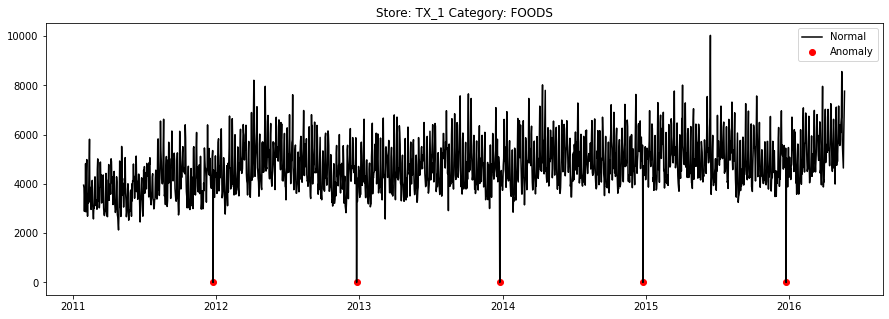

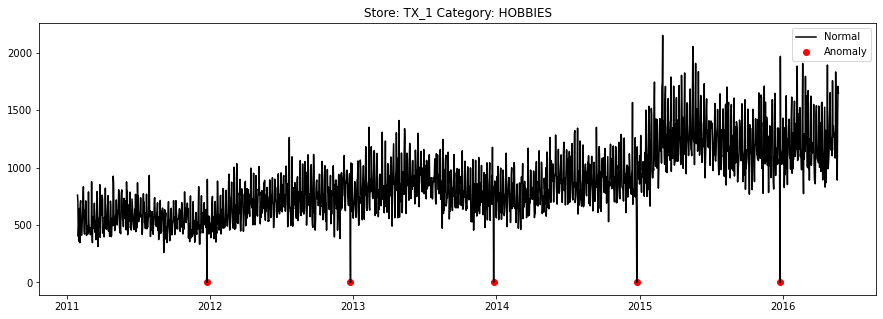

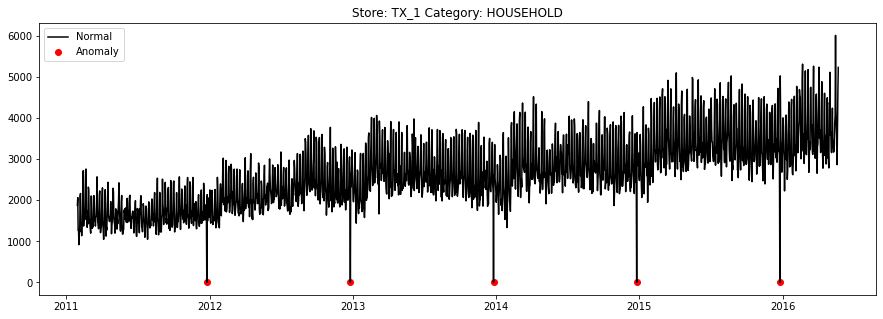

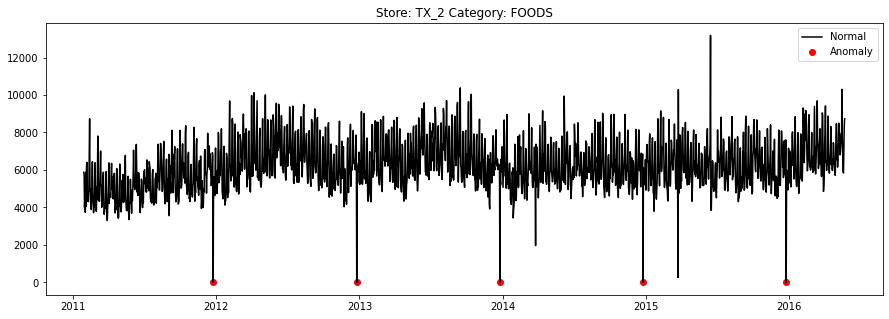

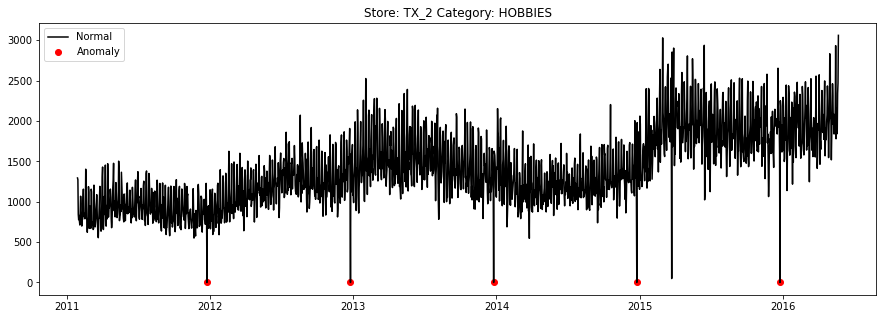

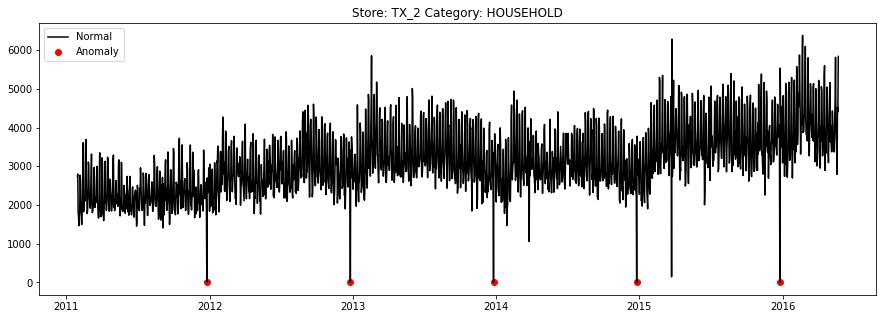

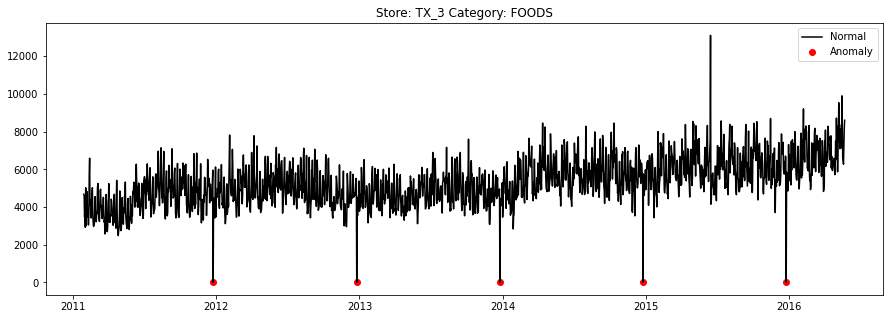

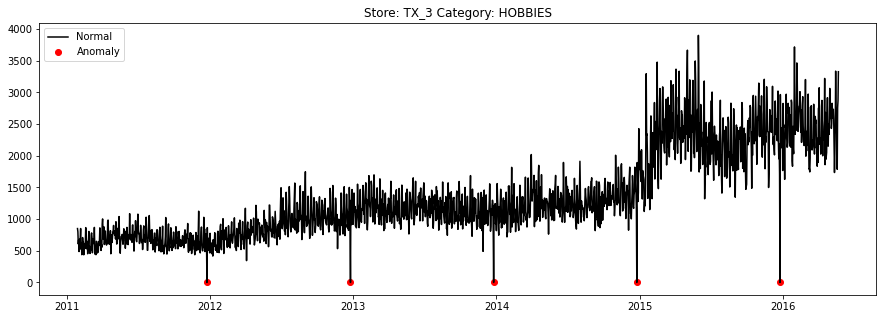

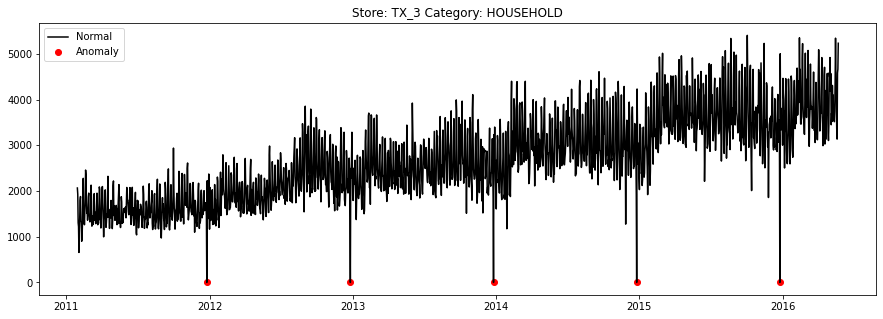

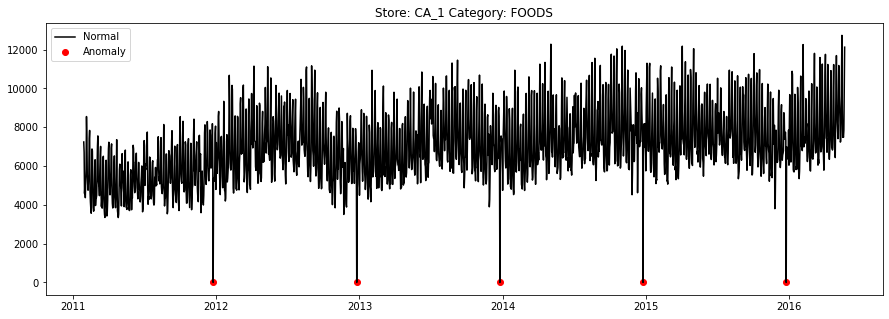

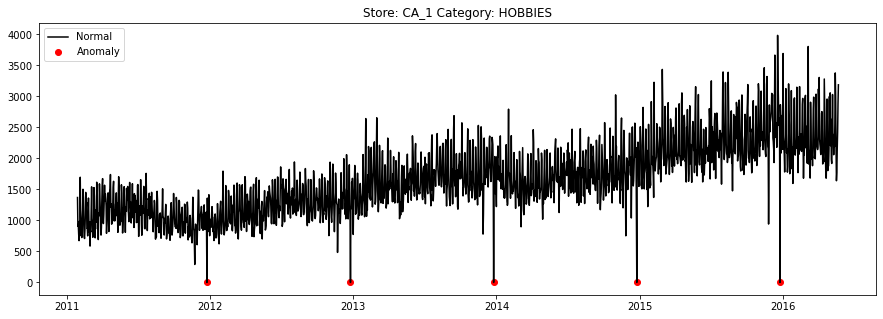

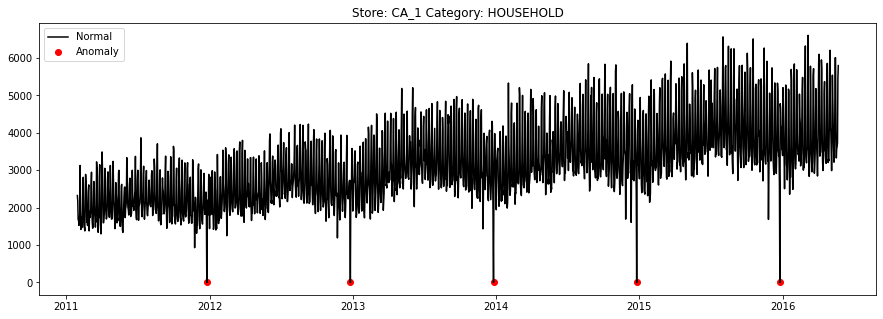

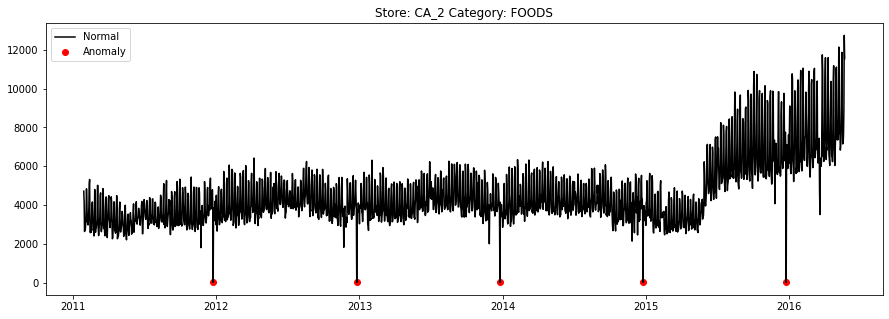

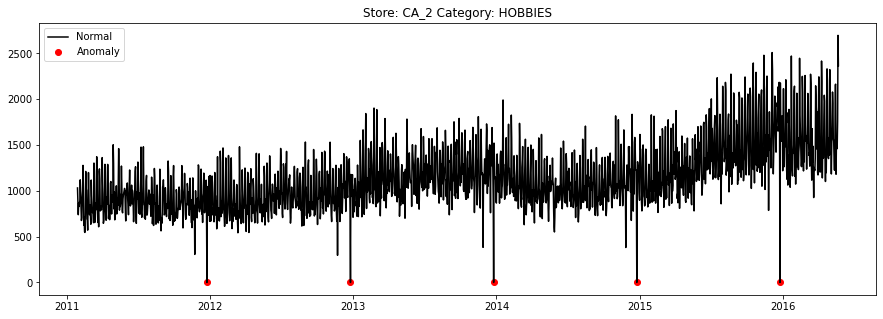

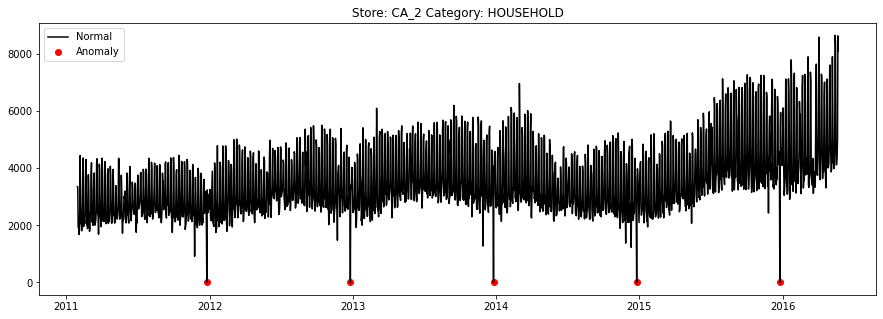

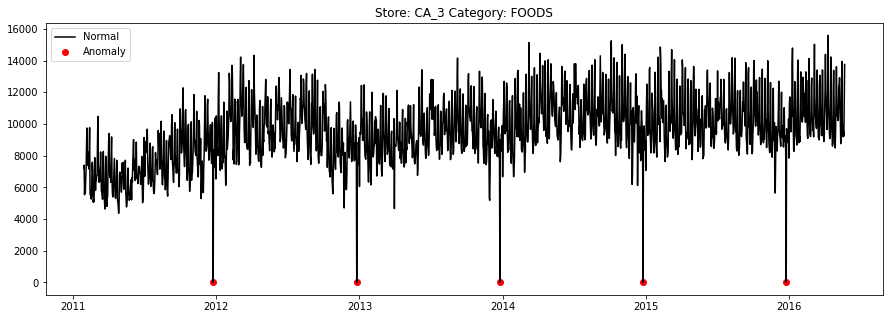

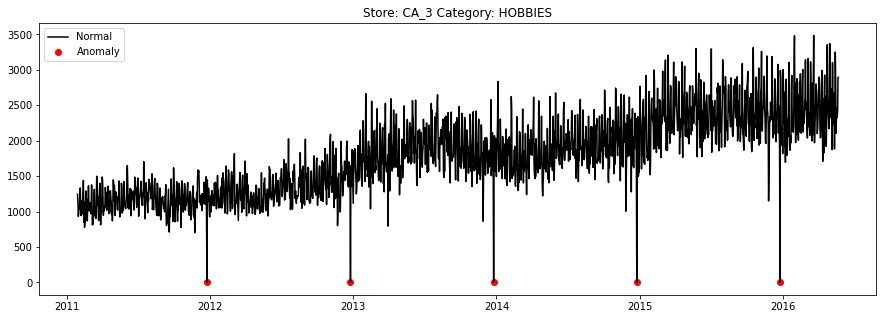

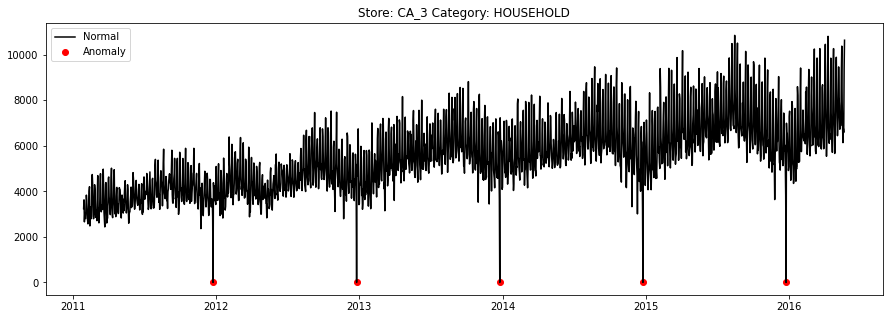

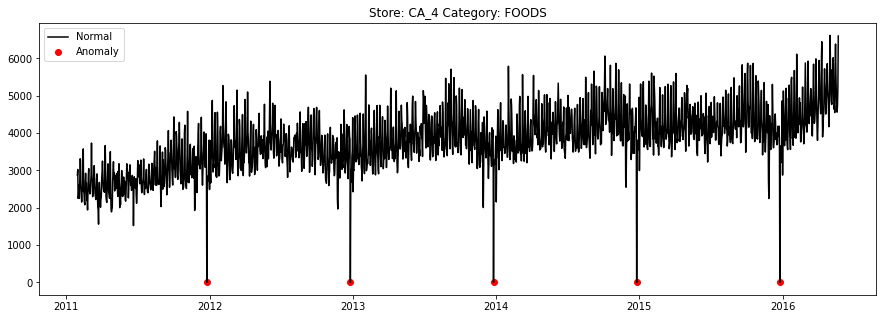

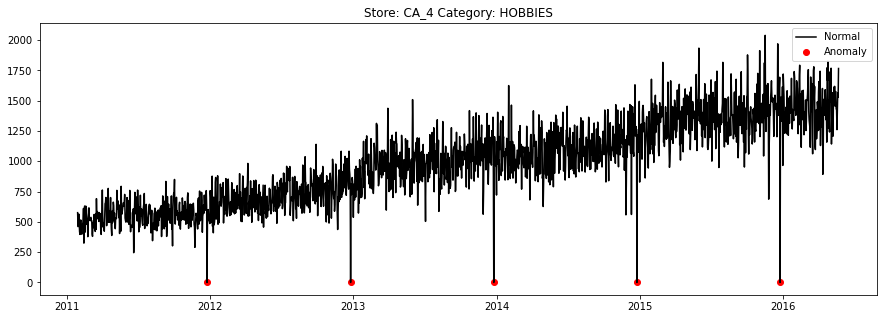

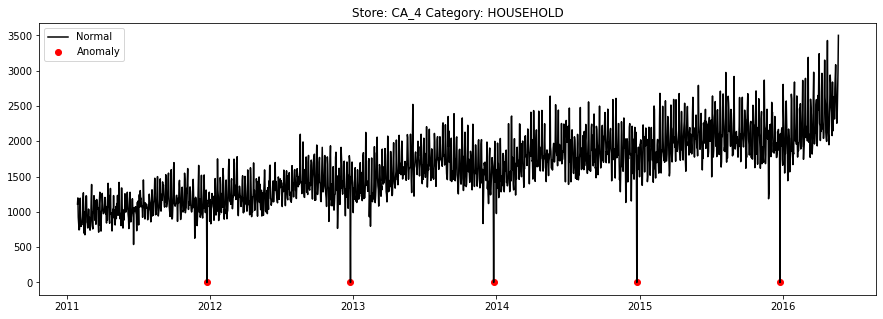

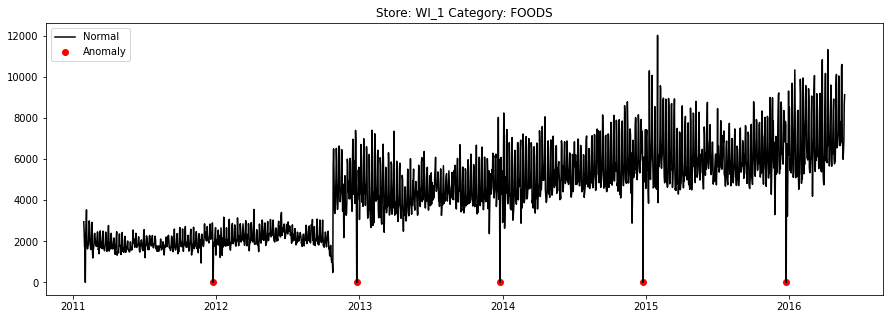

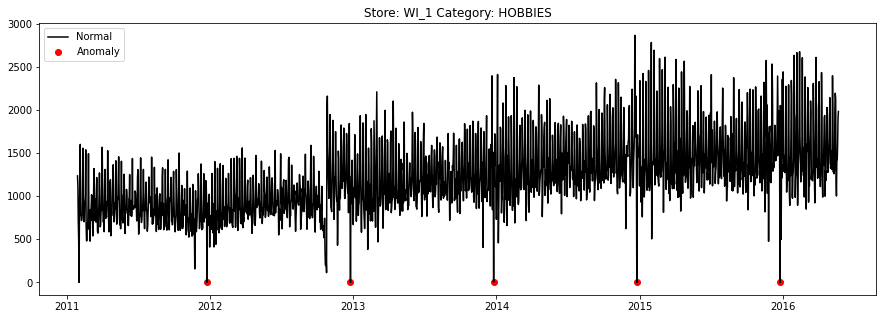

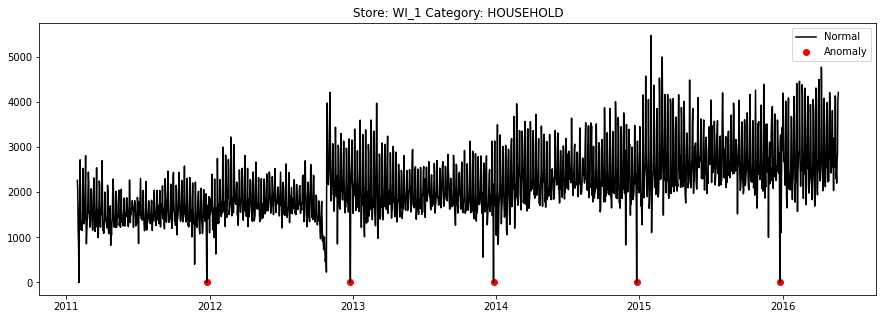

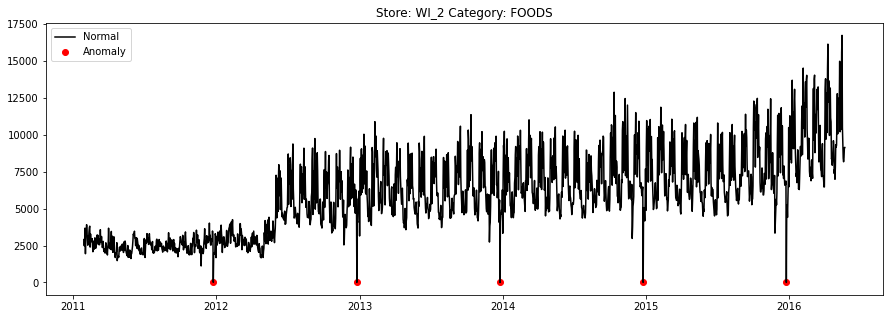

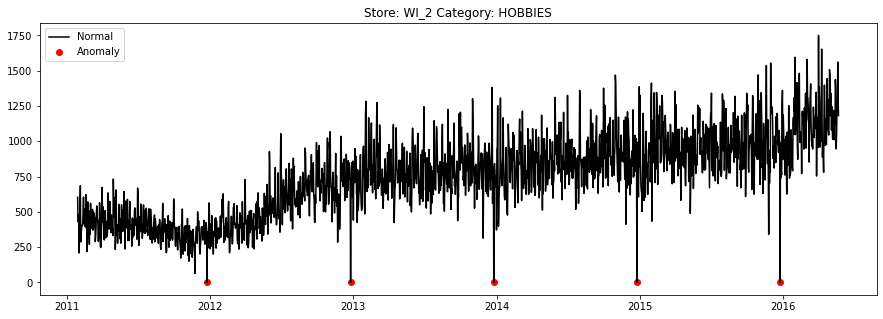

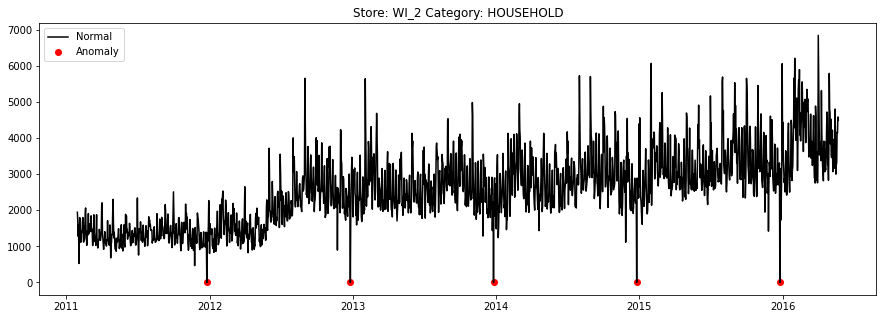

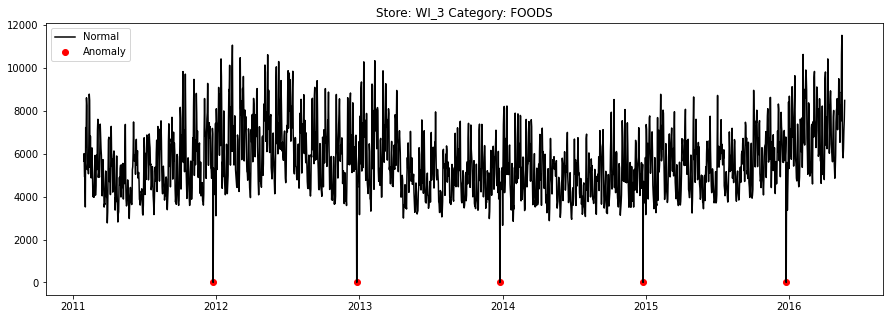

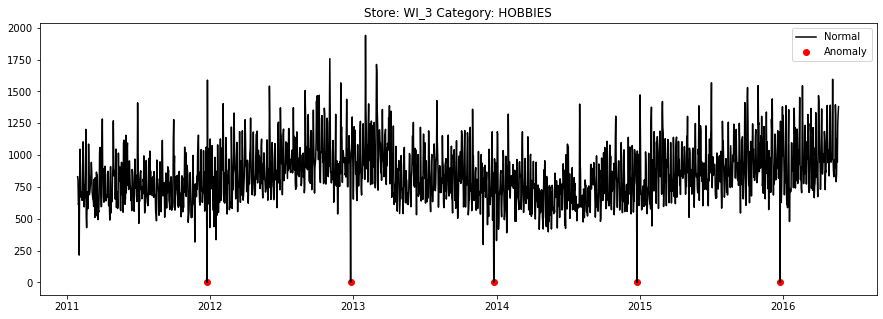

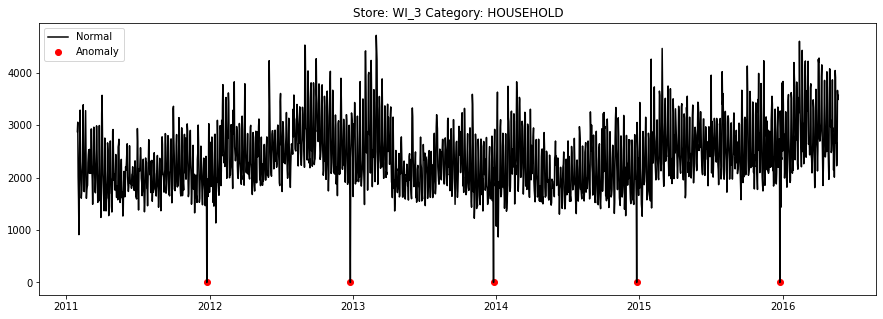

In [ ]:
#check the graph for every store and category combination
for store in sales_df.store_id.unique():
    for category in sales_df.cat_id.unique():
      visualize_outliers(store,category)

Later we will impute some value for these outlier points

### Missing values

In [ ]:
sum(outlier_marked_df.sales.isna())

0

No missing values in sales column

#### Imputing Outlier values

In [ ]:
outlier_marked_df.loc[outlier_marked_df['anomaly']==1, 'sales'] = np.nan

In [ ]:
sales_imputed_df = outlier_marked_df.set_index(['store_id', 'cat_id', 'date'])
sales_imputed_df.interpolate(inplace=True)
sales_imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 58230 entries, ('TX_1', 'FOODS', Timestamp('2011-01-29 00:00:00')) to ('WI_3', 'HOUSEHOLD', Timestamp('2016-05-22 00:00:00'))
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sales          58230 non-null  float64
 1   sales_detrend  58230 non-null  float64
 2   anomaly        58230 non-null  bool   
dtypes: bool(1), float64(2)
memory usage: 1.2+ MB


In [ ]:
sales_imputed_df.reset_index(inplace = True)

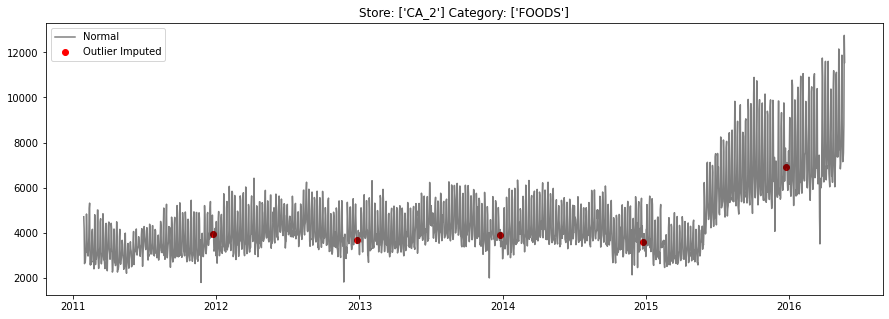

In [ ]:
def visualize_sales(store, category):
  '''
  To visualize the sales of a store and category
  '''

  sales_series_df = sales_imputed_df.loc[(sales_imputed_df.store_id == store) & (sales_imputed_df.cat_id==category), :]
  
  # visualization of sales
  fig, ax = plt.subplots(figsize=(15,5))
  a = sales_series_df.loc[sales_series_df['anomaly'] == 1, ['date', 'sales']] #anomaly
  ax.plot(sales_series_df.date, sales_series_df['sales'], color='black', label = 'Normal', alpha=0.5)
  ax.scatter(a.date, a['sales'], color='red', label = 'Outlier Imputed')
  plt.title(f'Store: {sales_series_df.store_id.unique()} Category: {sales_series_df.cat_id.unique()}')
  plt.legend()
  plt.show()

# sample one of the store category to see how our outlier detection performs
visualize_sales('CA_2', 'FOODS')

## Saving the preprocessed data

In [ ]:
! pwd

In [ ]:
sales_imputed_df.drop(columns=['sales_detrend', 'anomaly']).to_csv('./sales_processed.csv',index = False)

## Visualizing the TS data

Reference: https://plotly.com/python/time-series/

In [ ]:
import plotly.express as px
import seaborn as sns

In [ ]:
#Load saved data
sales_df = pd.read_csv('./sales_processed.csv', parse_dates=['date'])

In [ ]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58230 entries, 0 to 58229
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   store_id  58230 non-null  object        
 1   cat_id    58230 non-null  object        
 2   date      58230 non-null  datetime64[ns]
 3   sales     58230 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 1.8+ MB


In [ ]:
sales_df.store_id.unique()

array(['TX_1', 'TX_2', 'TX_3', 'CA_1', 'CA_2', 'CA_3', 'CA_4', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

In [ ]:
df1 = sales_df.query("store_id == 'TX_1' & cat_id == 'FOODS'")
fig = px.line(df1, x='date', y="sales")
fig.show()

In [ ]:
sales_transformed_df = pd.pivot_table(sales_df.loc[sales_df.cat_id==category], values='sales', index=['date'], columns=['store_id', 'cat_id'])
sales_transformed_df.reset_index(inplace=True)

In [ ]:
sales_transformed_df

store_id       date      CA_1      CA_2      CA_3      CA_4      TX_1  \
cat_id              HOUSEHOLD HOUSEHOLD HOUSEHOLD HOUSEHOLD HOUSEHOLD   
0        2011-01-29   2322.60   3357.57   3243.83   1109.97   1876.34   
1        2011-01-30   2173.91   3341.39   3624.94   1197.25   2064.04   
2        2011-01-31   1678.89   1950.06   2659.58    921.80   1262.27   
3        2011-02-01   1662.31   1956.95   3025.46    822.82   1263.71   
4        2011-02-02   1524.12   1680.57   2843.39    743.71    917.66   
...             ...       ...       ...       ...       ...       ...   
1936     2016-05-18   3579.01   4129.75   6135.51   2255.03   3539.09   
1937     2016-05-19   3623.99   4381.61   6754.94   2380.90   2864.29   
1938     2016-05-20   3729.30   4978.54   6582.41   2661.90   3900.31   
1939     2016-05-21   5440.14   8637.34   9369.80   2999.68   4653.96   
1940     2016-05-22   5795.43   8099.42  10632.29   3499.97   5228.94   

store_id      TX_2      TX_3      WI_1      WI_2      WI_3  
cat_id   HOUSEHOLD HOUSEHOLD HOUSEHOLD HOUSEHOLD HOUSEHOLD  
0          2743.84   2065.91   2265.40   1942.98   2876.72  
1          2799.81   1930.85   2044.30   1723.68   3057.48  
2          1817.25   1305.97   1161.30   1278.38   2016.65  
3          1674.63   1219.49    856.55   1599.68   1595.57  
4          1464.62    656.01      0.00    525.19    911.89  
...            ...       ...       ...       ...       ...  
1936       3318.89   3369.75   2202.03   3317.22   2225.31  
1937       2791.46   3135.19   2687.59   4158.05   2468.50  
1938       4526.45   4582.01   2874.37   4136.73   3664.25  
1939       4408.16   4666.97   4019.45   4582.43   3487.02  
1940       5838.91   5231.87   4213.33   4499.18   3566.90  

[1941 rows x 11 columns]

In [ ]:
def show_sales(df, category):
    """
    Plot interactive line charts of sales
    """
    sales_df_transformed = pd.pivot_table(df.loc[df.cat_id==category], values='sales', index=['date'], columns=['store_id', 'cat_id'])
    sales_df_transformed.reset_index(inplace=True)
    sales_df_transformed.columns = [' '.join(col).strip() for col in sales_df_transformed.columns.values]

    fig = px.line(sales_df_transformed, x="date", y=sales_df_transformed.columns,
                  hover_data={"date": "|%B %d, %Y"},
                  title='Daily Retail Sales by Store and Category')
    fig.update_xaxes(
        dtick="M1",
        tickformat="%b\n%Y")
    fig.show()

In [ ]:
# plot for FOODS category
show_sales(sales_df, 'FOODS')

In [ ]:
# plot for HOUSEHOLD category
show_sales(sales_df, 'HOUSEHOLD')

In [ ]:
# plot for HOBBIES category
show_sales(sales_df, 'HOBBIES')

From our Plotly diagrams, we can see that there are some time series which have abrupt breaks in trend. These breaks will not be helpful for our models later, so we should remove the past data before the breaks.

In [ ]:
sales_df_clean = sales_df.copy()
sales_df_clean['series_id'] = sales_df_clean['store_id'] + '_' + sales_df_clean['cat_id']

# indicator to mark data points to drop
sales_df_clean['drop_ind'] = ((sales_df_clean.series_id=='CA_2_FOODS') & (sales_df_clean.date < '2015-06-01')) | \
                            ((sales_df_clean.series_id=='WI_1_FOODS') & (sales_df_clean.date < '2012-11-01')) | \
                            ((sales_df_clean.series_id=='WI_2_FOODS') & (sales_df_clean.date < '2012-06-01')) | \
                            ((sales_df_clean.series_id=='WI_1_HOUSEHOLD') & (sales_df_clean.date < '2012-11-01')) | \
                            ((sales_df_clean.series_id=='WI_2_HOUSEHOLD') & (sales_df_clean.date < '2012-06-01'))

# drop the data points identified as past data before trend breaks
sales_df_clean = sales_df_clean.loc[sales_df_clean.drop_ind==False]
sales_df_clean.drop(columns=['drop_ind'], inplace=True)
sales_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54384 entries, 0 to 58229
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   store_id   54384 non-null  object        
 1   cat_id     54384 non-null  object        
 2   date       54384 non-null  datetime64[ns]
 3   sales      54384 non-null  float64       
 4   series_id  54384 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 2.5+ MB


## Seasonality Identification

Analyzing and visualizing the retail sales by weekday, month and year for a Time Series, or in other words to identify trend and seasonality patterns.

In [ ]:
# filter for a time series
store = 'TX_1'
category = 'FOODS'
sales_series_df_plot = sales_df_clean.loc[(sales_df_clean.store_id==store) & (sales_df_clean.cat_id==category)]

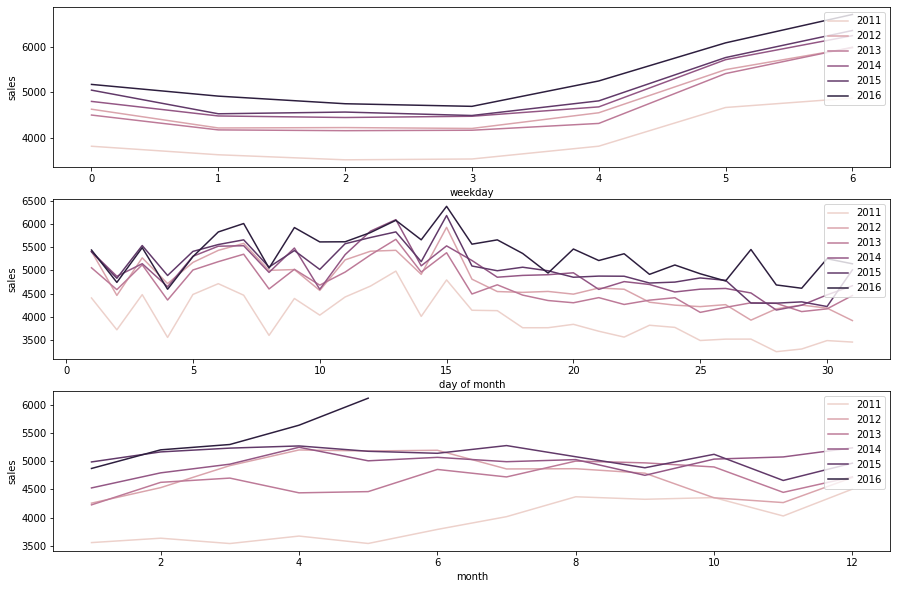

In [ ]:
# line charts by weekday, day of month, and month, group by year
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,10))

sns.lineplot(x=sales_series_df_plot.date.dt.weekday, y=sales_series_df_plot.sales, hue=sales_series_df_plot.date.dt.year, ax=ax[0], ci=None)
sns.lineplot(x=sales_series_df_plot.date.dt.day, y=sales_series_df_plot.sales, hue=sales_series_df_plot.date.dt.year, ax=ax[1], ci=None)
sns.lineplot(x=sales_series_df_plot.date.dt.month, y=sales_series_df_plot.sales, hue=sales_series_df_plot.date.dt.year, ax=ax[2], ci=None)

ax[0].set_xlabel('weekday')
ax[1].set_xlabel('day of month')
ax[2].set_xlabel('month')

ax[0].legend(loc="upper right")
ax[1].legend(loc="upper right")
ax[2].legend(loc="upper right")

From above plots, we can clearly see a strong weekday pattern and some monthly seasonality: 
- Sales tend to be higher on Friday and weekends
- Mid of the month spike in sales followed by a trend downwards for rest of month
- No obvious yearly seasonality

Besides using plots, let us use peridogram to find the period more objectively

In [ ]:
def detrend_series(store, category):
    """
    Detrend the sales of a time series and return the detrended sales value, 
    the trend identified, and the original sales 
    """
    df_series = sales_df.loc[(sales_df.store_id==store) & (sales_df.cat_id==category)]
    # savgol_filter is used to better detrend sales. Alternatively scipy detrend can also be used
    data_trend = savgol_filter(df_series['sales'].values,365,1)
    data_detrended = (df_series['sales'] - data_trend).values
    return data_detrended, data_trend, df_series

def summarise_periodicity(data_detrended):
    """
    Extract important frequency values with periodogram
    """
    f, Periodogram = signal.periodogram(data_detrended)
    # Make dataframe for finding frequency with highest power spectrum
    data = {'interval':1/f, 'power_spectral_density':Periodogram}
    df_periodogram = pd.DataFrame(data = data)
    df_periodogram.sort_values(by=['power_spectral_density'], ascending=False, inplace=True)
    return df_periodogram[:3] # retrieve top three frequency values

def plot_series_trend(df_series, data_trend, data_detrended):
    """
    Plot original and detrended sales of time series 
    """
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    ax[0].plot(df_series['date'].values, df_series['sales'].values)
    ax[0].plot(df_series['date'].values, data_trend)
    ax[1].plot(df_series['date'].values, data_detrended)
    ax[0].title.set_text('Sales with trend line')
    ax[1].title.set_text('Sales detrended')
    ax[0].set_ylabel('Sales')
    plt.show()

def plot_periodicity(data_detrended):
    """
    Plot periodogram
    """
    f, Periodogram = signal.periodogram(data_detrended)
    plt.plot(f, Periodogram)
    plt.title("Periodogram")
    plt.xlabel('Frequency')
    plt.ylabel('Power Spectrum')
    plt.show()

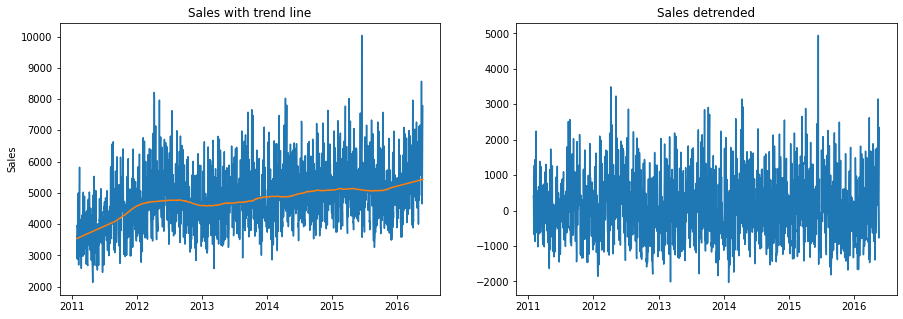

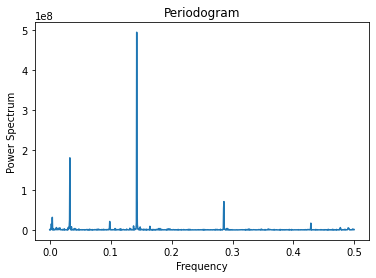

In [ ]:
store = 'TX_1'
category = 'FOODS'
data_detrended, data_trend, df_series = detrend_series(store, category)

# plot time series original and detrended sales
plot_series_trend(df_series, data_trend, data_detrended)

# plot periodogram
plot_periodicity(data_detrended)

After sampling a few time series and analysing the periodograms, we can see that there are generally 2-3 significant frequency values. One of them has an especially large power spectral density compared to the other frequency values. We can guess that this is probably the weekly seasonality based on our earlier analysis of the plots.

In [ ]:
periodogram_list = []

for store in sales_df.store_id.unique():
    for category in sales_df.cat_id.unique():
        data_detrended, data_trend, df_series = detrend_series(store, category)
        periodicity_df = summarise_periodicity(data_detrended)
        periodogram_list.append(periodicity_df)

periodogram_df = pd.concat(periodogram_list)
periodogram_df['interval'] = periodogram_df['interval'].round(0).astype(int)
periodogram_df.sort_values(by='power_spectral_density', ascending=False, inplace=True)
periodogram_df.interval.value_counts()

<ipython-input-45-7d7291cd1377>:18: RuntimeWarning:

divide by zero encountered in true_divide



7      57
30     11
3      11
323     4
4       3
31      2
277     1
243     1
Name: interval, dtype: int64

By filtering the top 3 frequency values for each time series and summarising the counts of the time intervals, we are able to clearly identify the weekly (time interval 7) and monthly seasonalities (time interval 30). We can ignore the rest of the time intervals that are not as frequently occurring.

**We can conclude a weekly seasonality from periodogram**

## Train, Val and Test Split

Train-test split returns the split's training, validation and test data. Since we are required to forecast for the next 28 days, we can set 28 days as the period for test and validation data.

In [ ]:
def get_cv_split(df, prediction_length):

  """
  Implement train-test split given a prediction length and return training, val and test data
  """
  if 'series_id' not in df.columns:
    df['series_id'] = df['store_id'] + '_' + df['cat_id']

  series_list = df['series_id'].unique()

  test_list = []
  validation_list = []
  training_list = []

  for series in series_list:
    df_series = df.loc[df.series_id==series]
    max_date = df_series.date.max()
    min_date = df_series.date.min()
    test_lower_date = max_date - pd.Timedelta(f"{prediction_length} days")
    test_upper_date = max_date
    val_lower_date = max_date - pd.Timedelta(f"{prediction_length*(1)*2} days")
    if min(test_lower_date, test_upper_date) < min_date:
        raise Exception("Insufficient data for splitting")

    df_series_test = df_series.loc[(df_series.date > test_lower_date) & (df_series.date <= test_upper_date)]
    df_series_val = df_series.loc[(df_series.date > val_lower_date) & (df_series.date <= test_lower_date)]
    df_series_train = df_series.loc[df_series.date <= val_lower_date]
    
    test_list.append(df_series_test)
    validation_list.append(df_series_val)
    training_list.append(df_series_train)

  test_df = pd.concat(test_list)
  validation_df = pd.concat(validation_list)
  training_df = pd.concat(training_list)
  return training_df, validation_df, test_df

In [ ]:
training_df, validation_df, test_df = get_cv_split(sales_df_clean,prediction_length=28)
print(f"Test data is from {test_df.date.min()} to {test_df.date.max()}")
print(f"Validation data is from {validation_df.date.min()} to {validation_df.date.max()}")
print(f"Training data is till {training_df.date.max()}")

Test data is from 2016-04-25 00:00:00 to 2016-05-22 00:00:00
Validation data is from 2016-03-28 00:00:00 to 2016-04-24 00:00:00
Training data is till 2016-03-27 00:00:00


In [ ]:
print(f"Test data consists of {len(test_df.loc[test_df.series_id=='TX_1_FOODS'])} days")
print(f"Validation data consists of {len(validation_df.loc[validation_df.series_id=='TX_1_FOODS'])} days")

Test data consists of 28 days
Validation data consists of 28 days


In [ ]:
#save the data
sales_df_clean.to_csv('./sales_cleaned.csv',index = False)
training_df.to_csv('./sales_cleaned_train.csv', index=False)
validation_df.to_csv('./sales_cleaned_val.csv', index=False)
test_df.to_csv('./sales_cleaned_test.csv', index=False)